In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import fiftyone as fo
from fiftyone import ViewField as F
import matplotlib.pyplot as plt
import numpy as np
from tracking import TrackingMetrics
from tracking.utils import compute_metrics_by_sequence, results_to_df, \
                            results_to_csv, get_sequence_info, \
                                classify_num_objects
from collections import Counter

In [3]:
dataset = fo.load_dataset("SENTRY_VIDEOS_DATASET_QA")
det_gt_field = "ground_truth_det"

In [4]:
area_ranges_tuples = [
    
    ("tiny", [0, 1.53 ** 2]),
    ("small", [1.53 ** 2, 6 ** 2]),
    ("medium", [6 ** 2, 12 ** 2]),
    ("large", [12 ** 2, 1e5 ** 2])
]
area_ranges = [v for k, v in area_ranges_tuples]
area_ranges_labels = [k for k, v in area_ranges_tuples]
area_ranges_tuples

[('tiny', [0, 2.3409]),
 ('small', [2.3409, 36]),
 ('medium', [36, 144]),
 ('large', [144, 10000000000.0])]

In [5]:
a = get_sequence_info(view = dataset.select_group_slices(["thermal_wide"]) \
                                                    .match_tags("LONG_VIDEOS", False) \
                                                    .match_tags("TRACKER_TEST", True)
                                                    ,
                gt_field=det_gt_field,
                )

100%|██████████| 17/17 [00:02<00:00,  7.26it/s]


Error in sequence Sentry_2022_08_Portugal_2022_08_16_11_29_37


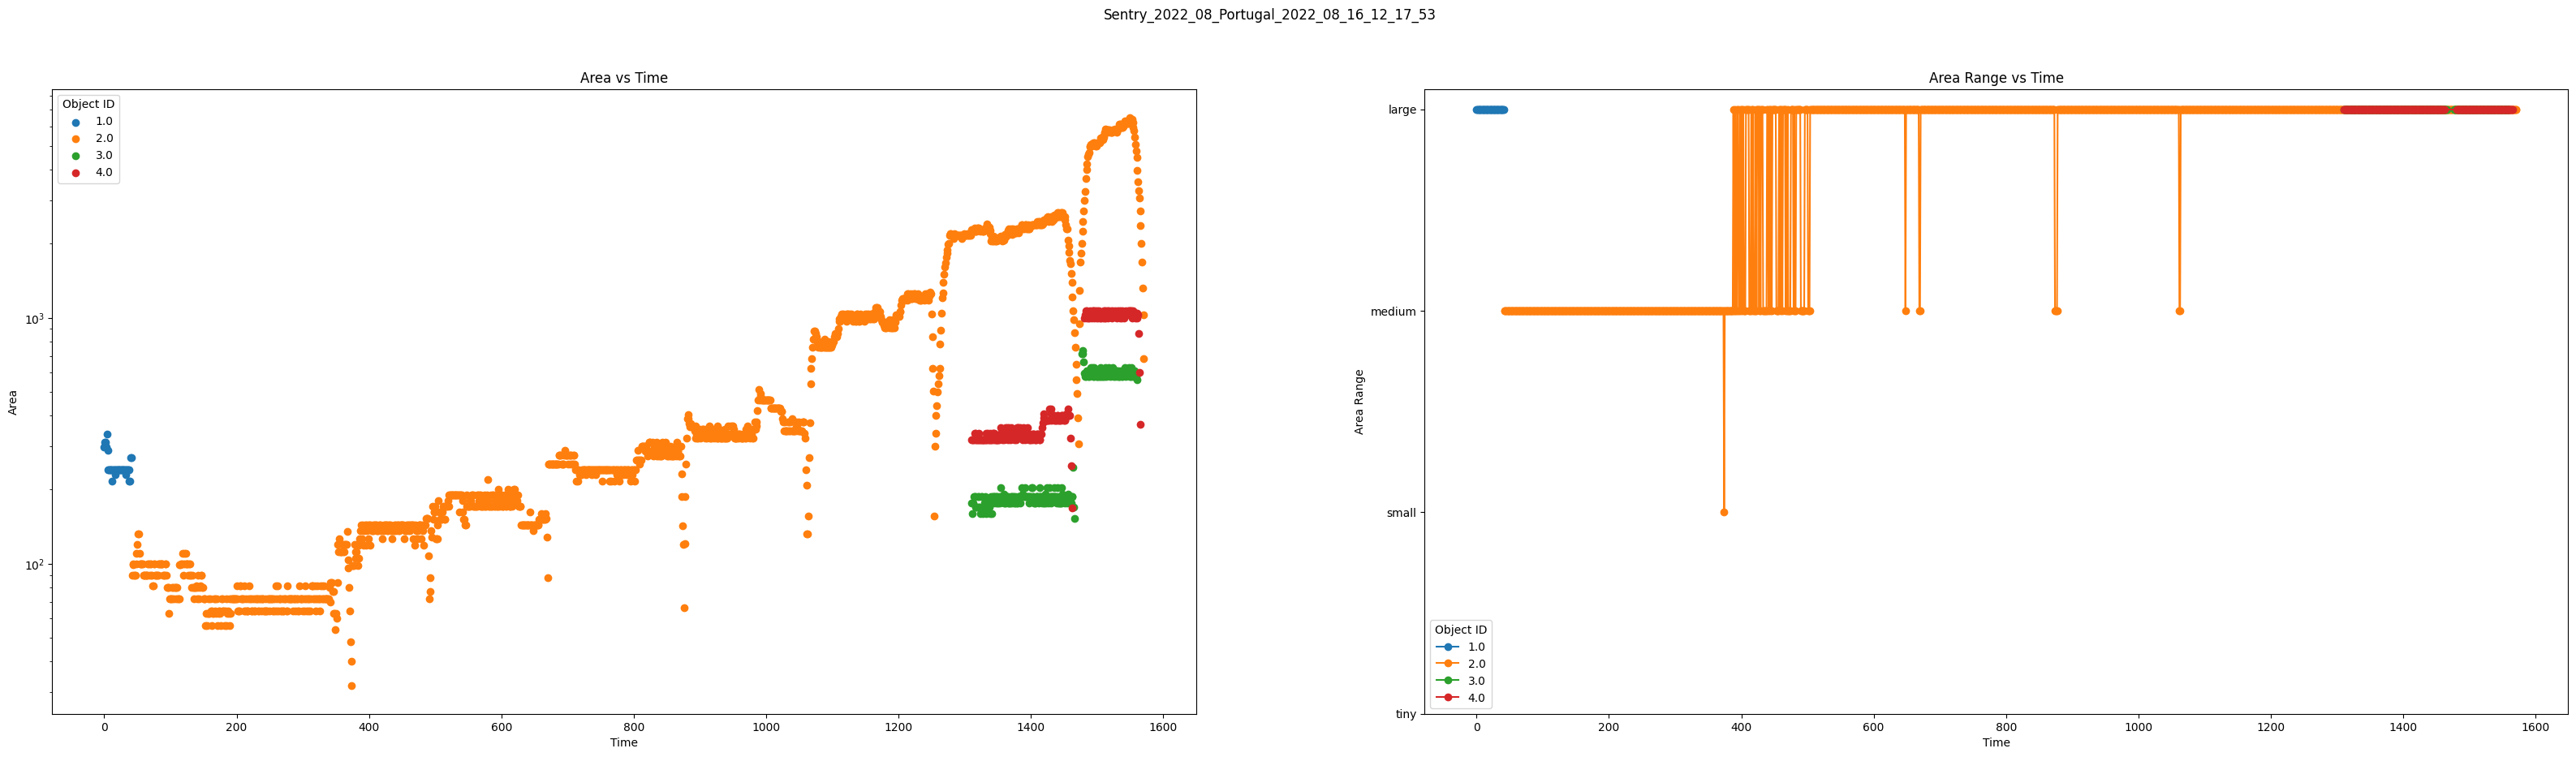

Plotted sequence Sentry_2022_08_Portugal_2022_08_16_12_17_53


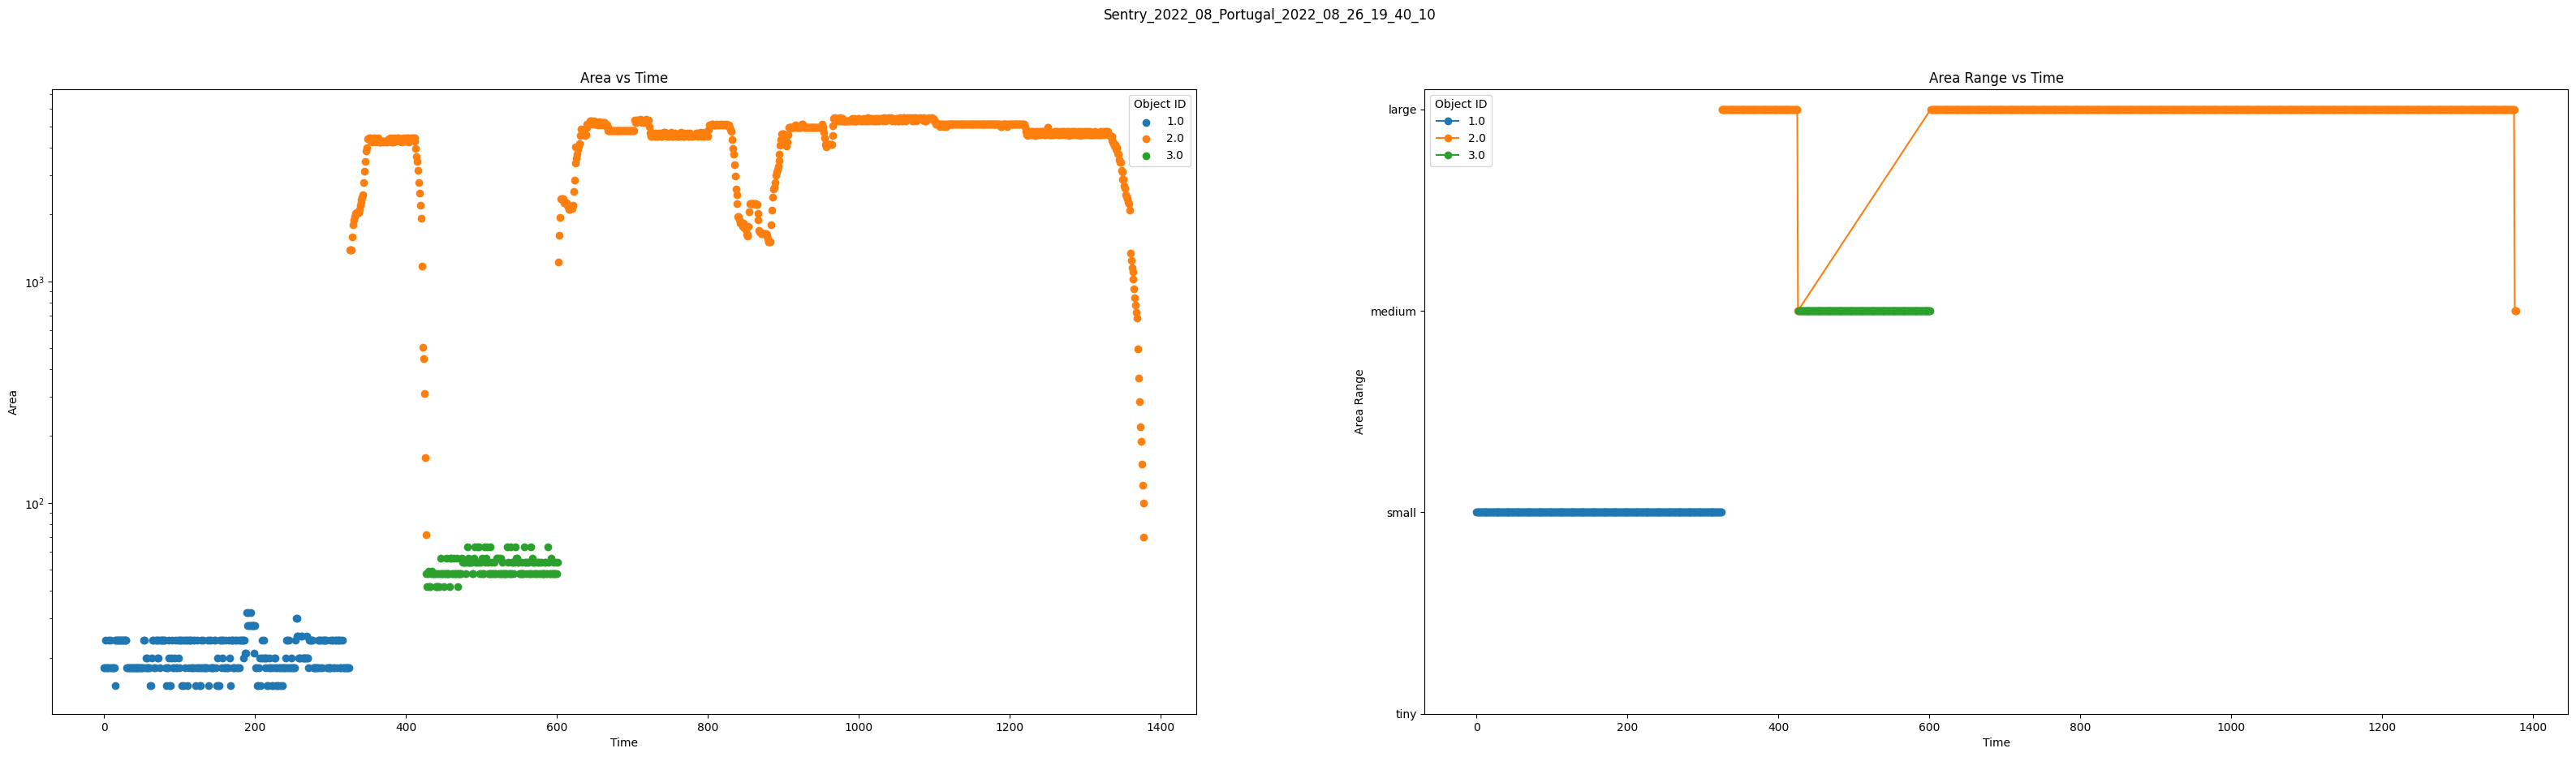

Plotted sequence Sentry_2022_08_Portugal_2022_08_26_19_40_10
Error in sequence Sentry_2022_08_Portugal_2022_08_29_20_32_19


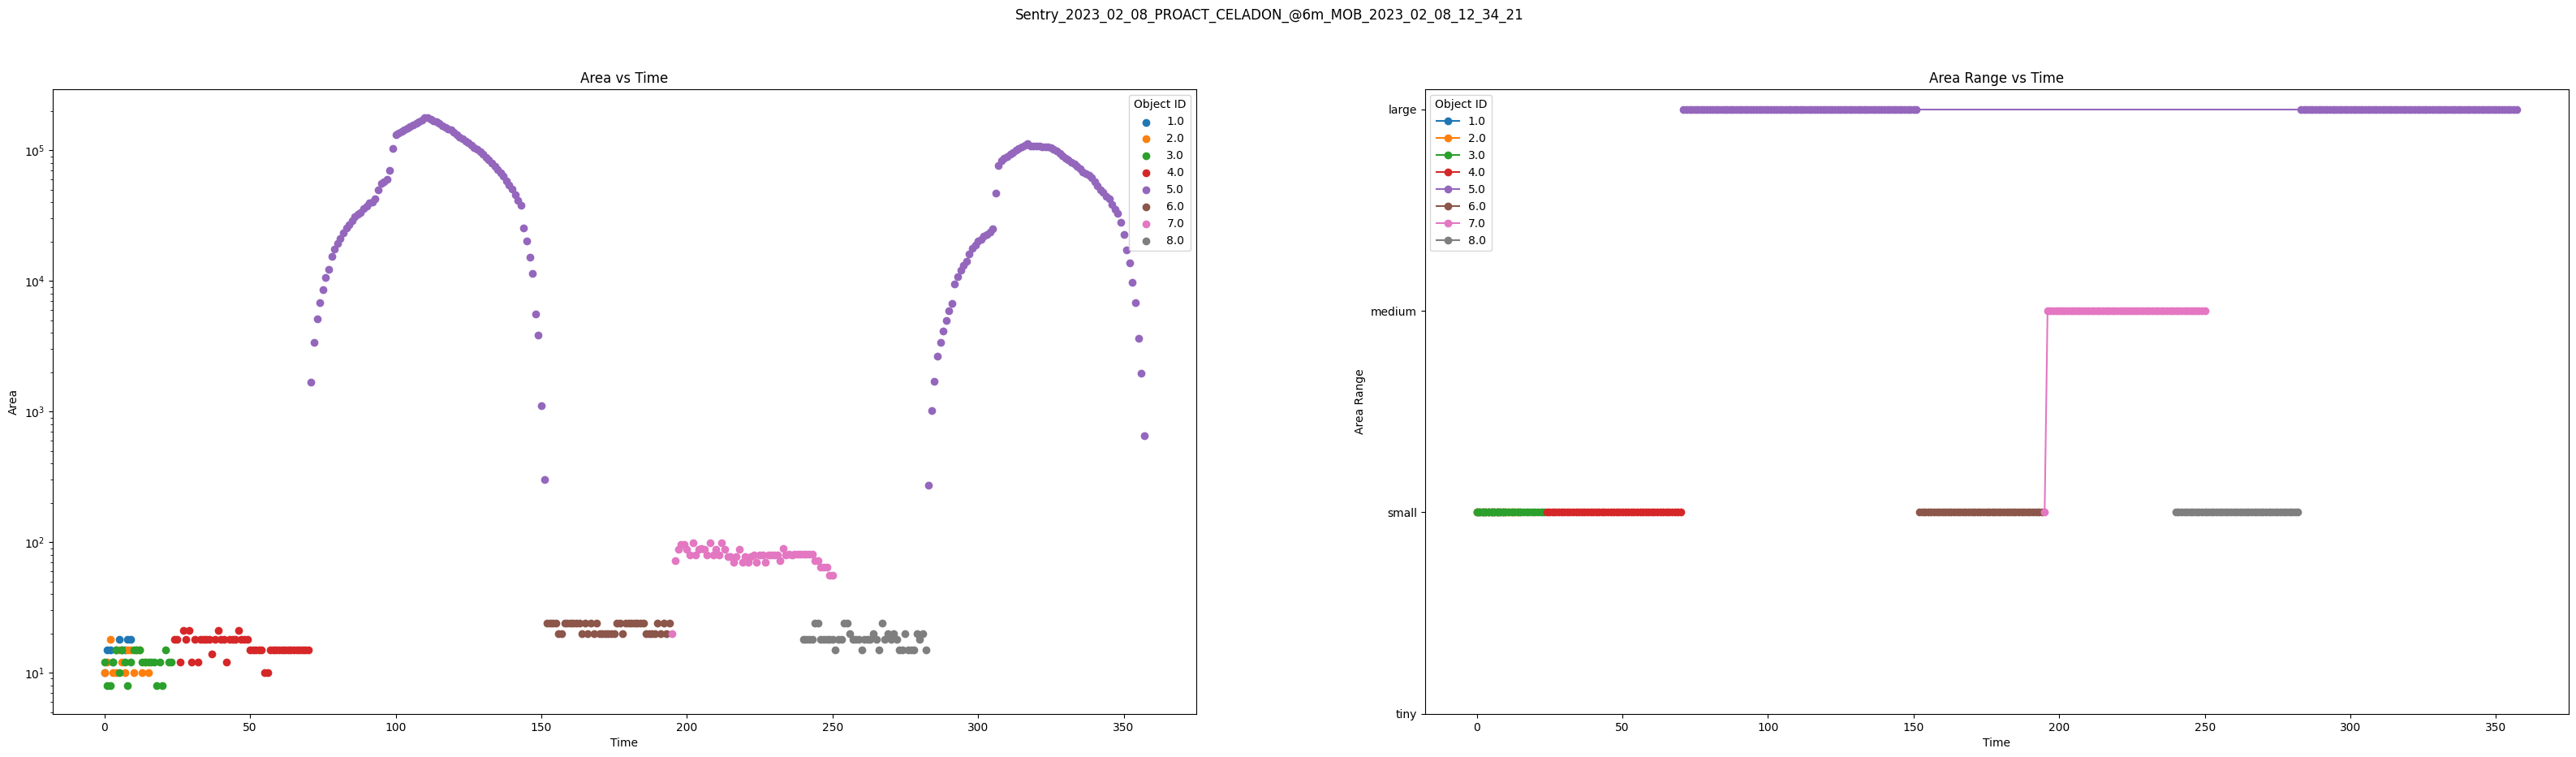

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_34_21


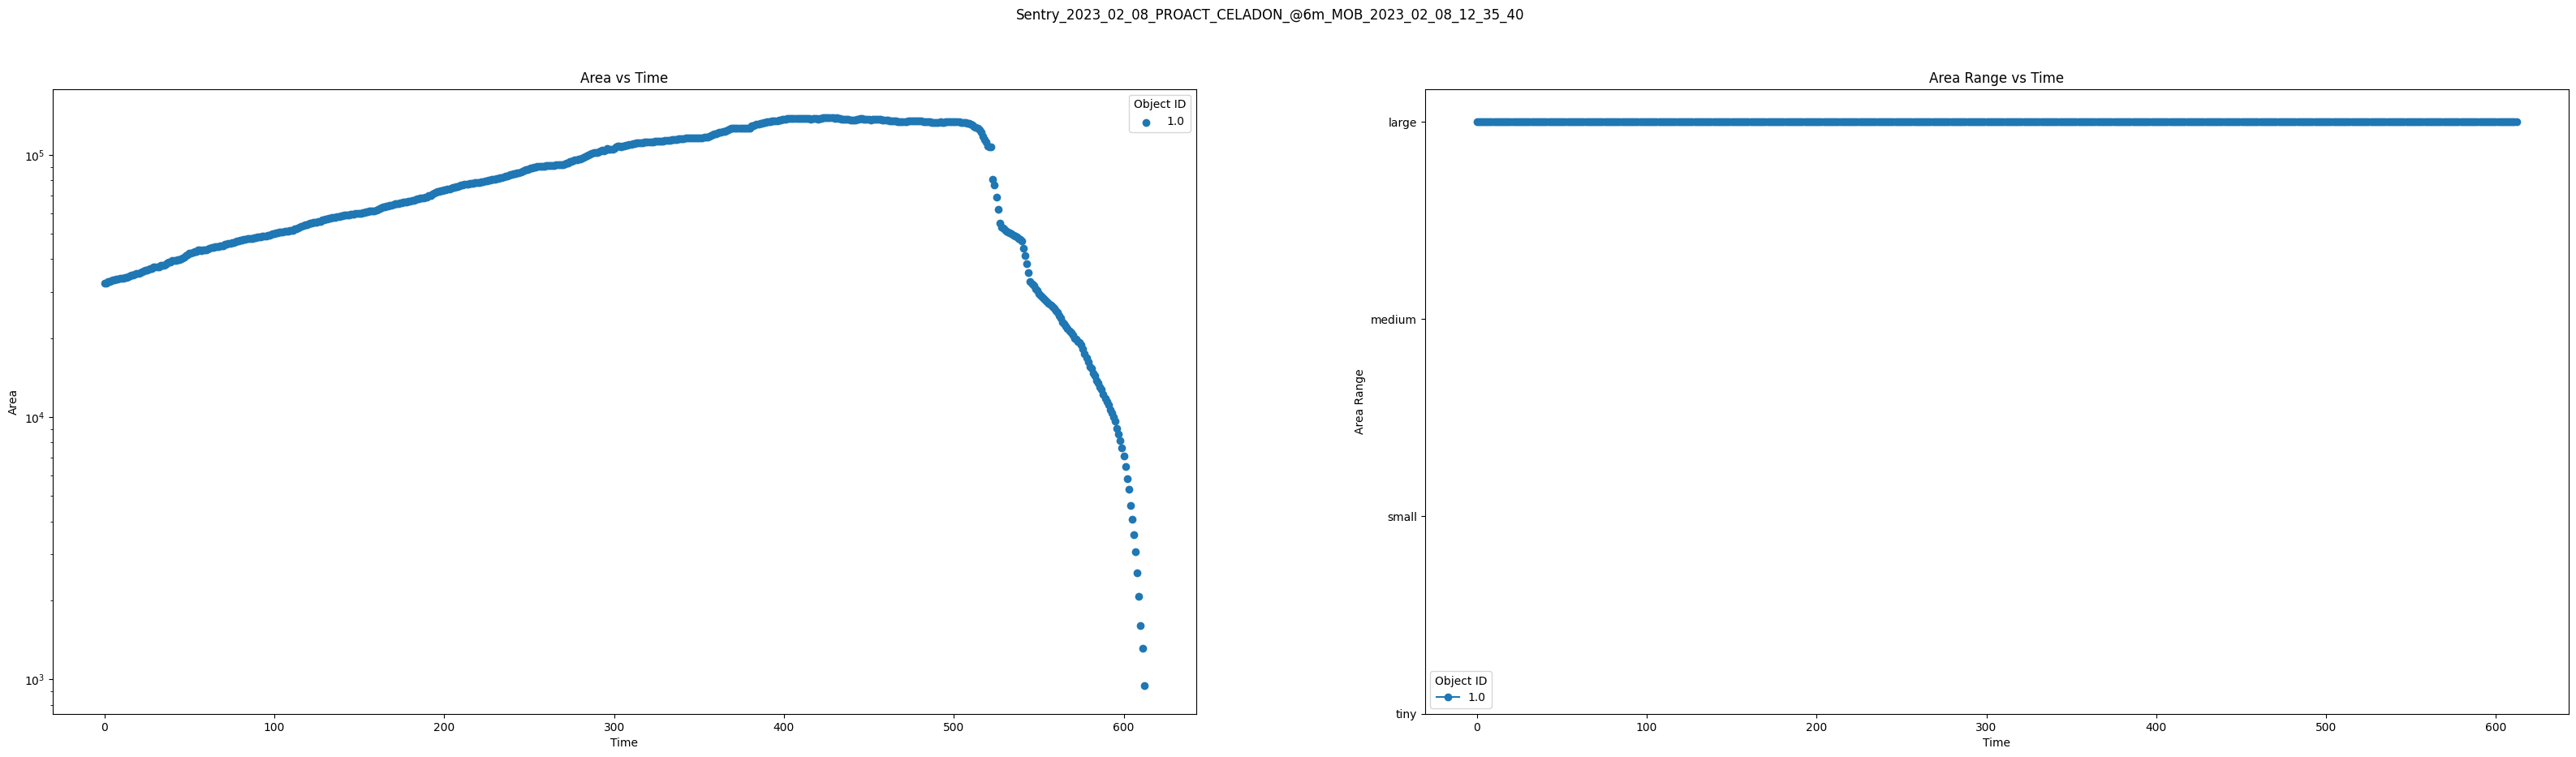

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_35_40


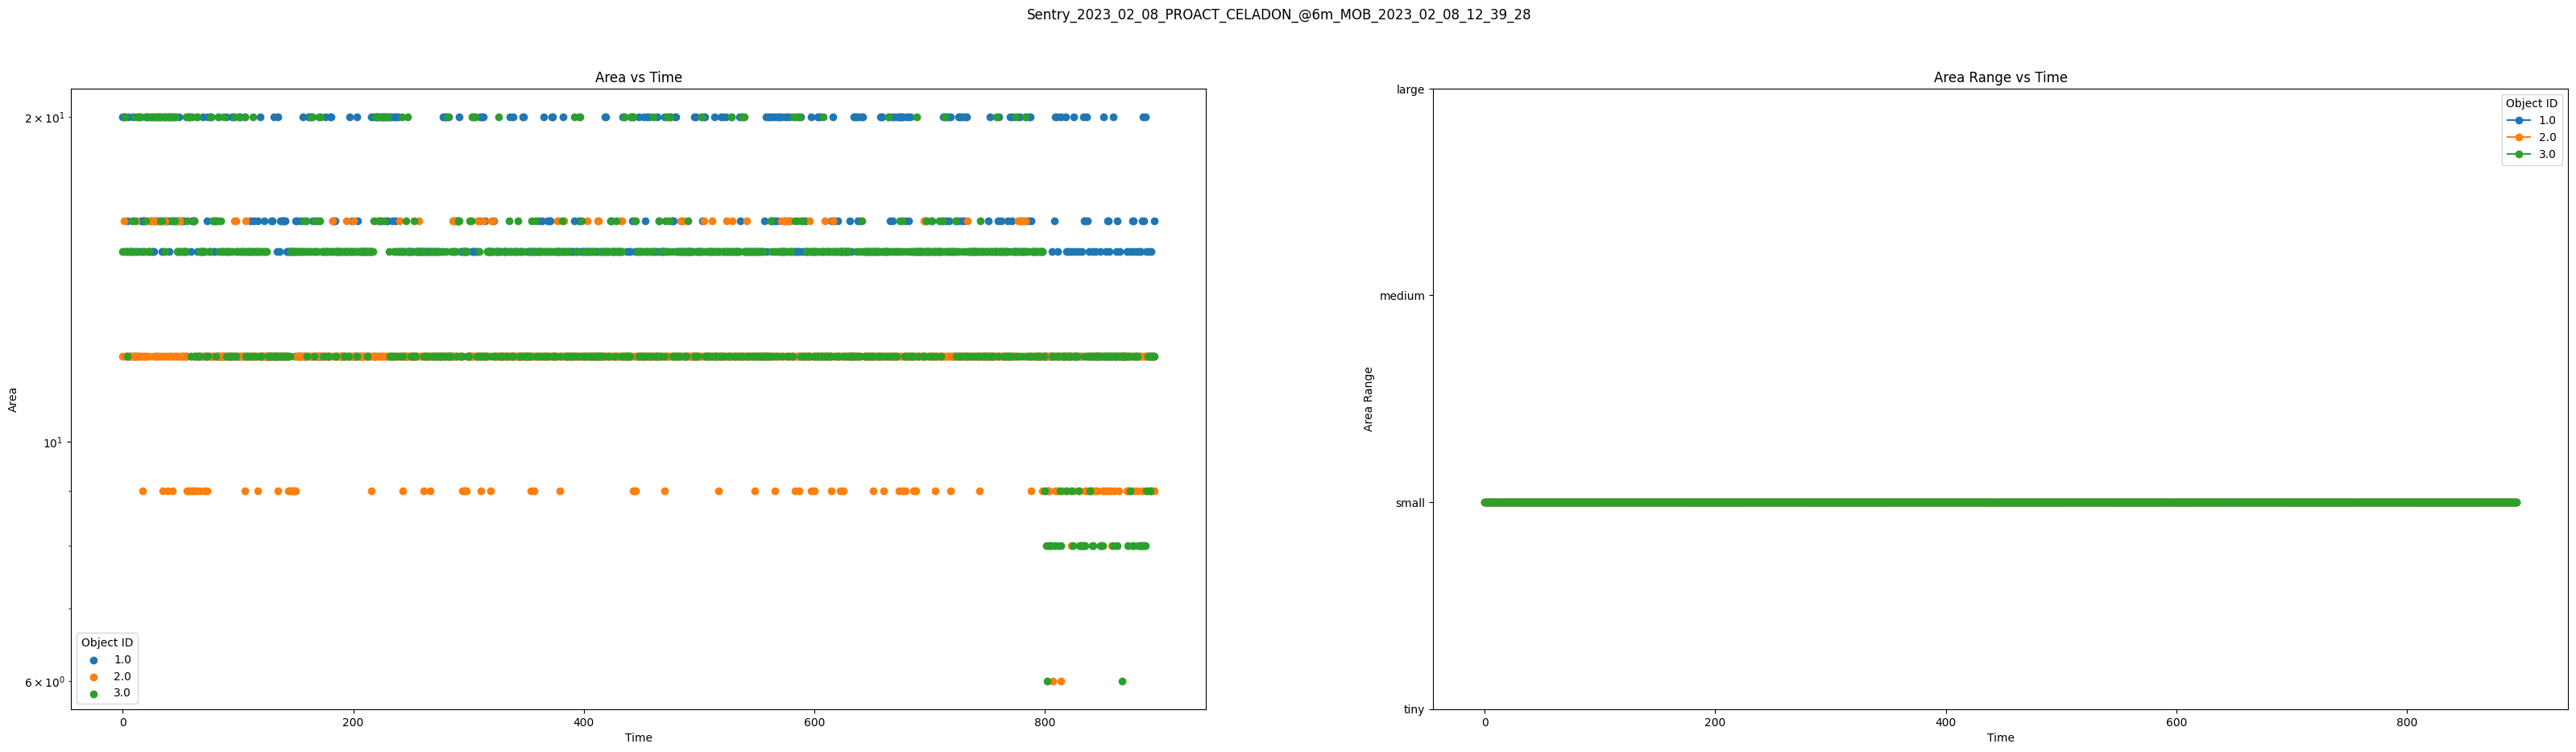

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_39_28


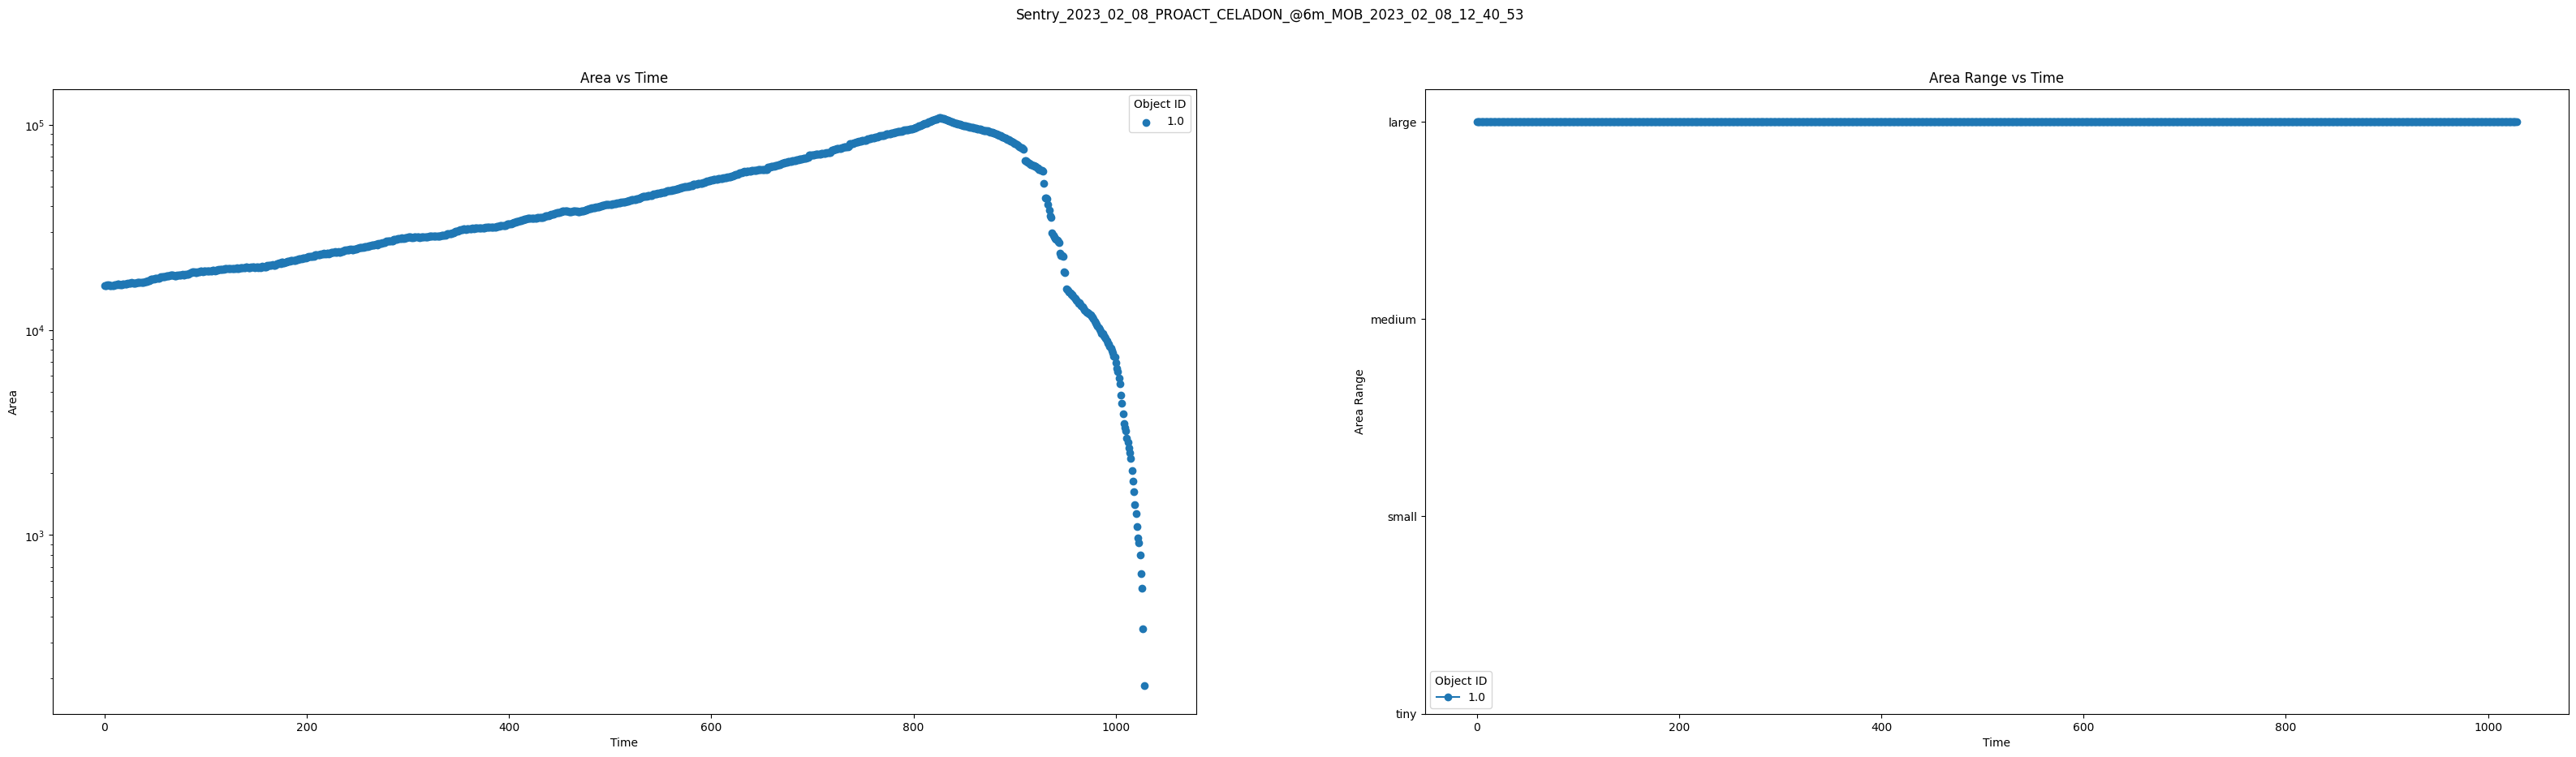

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_40_53


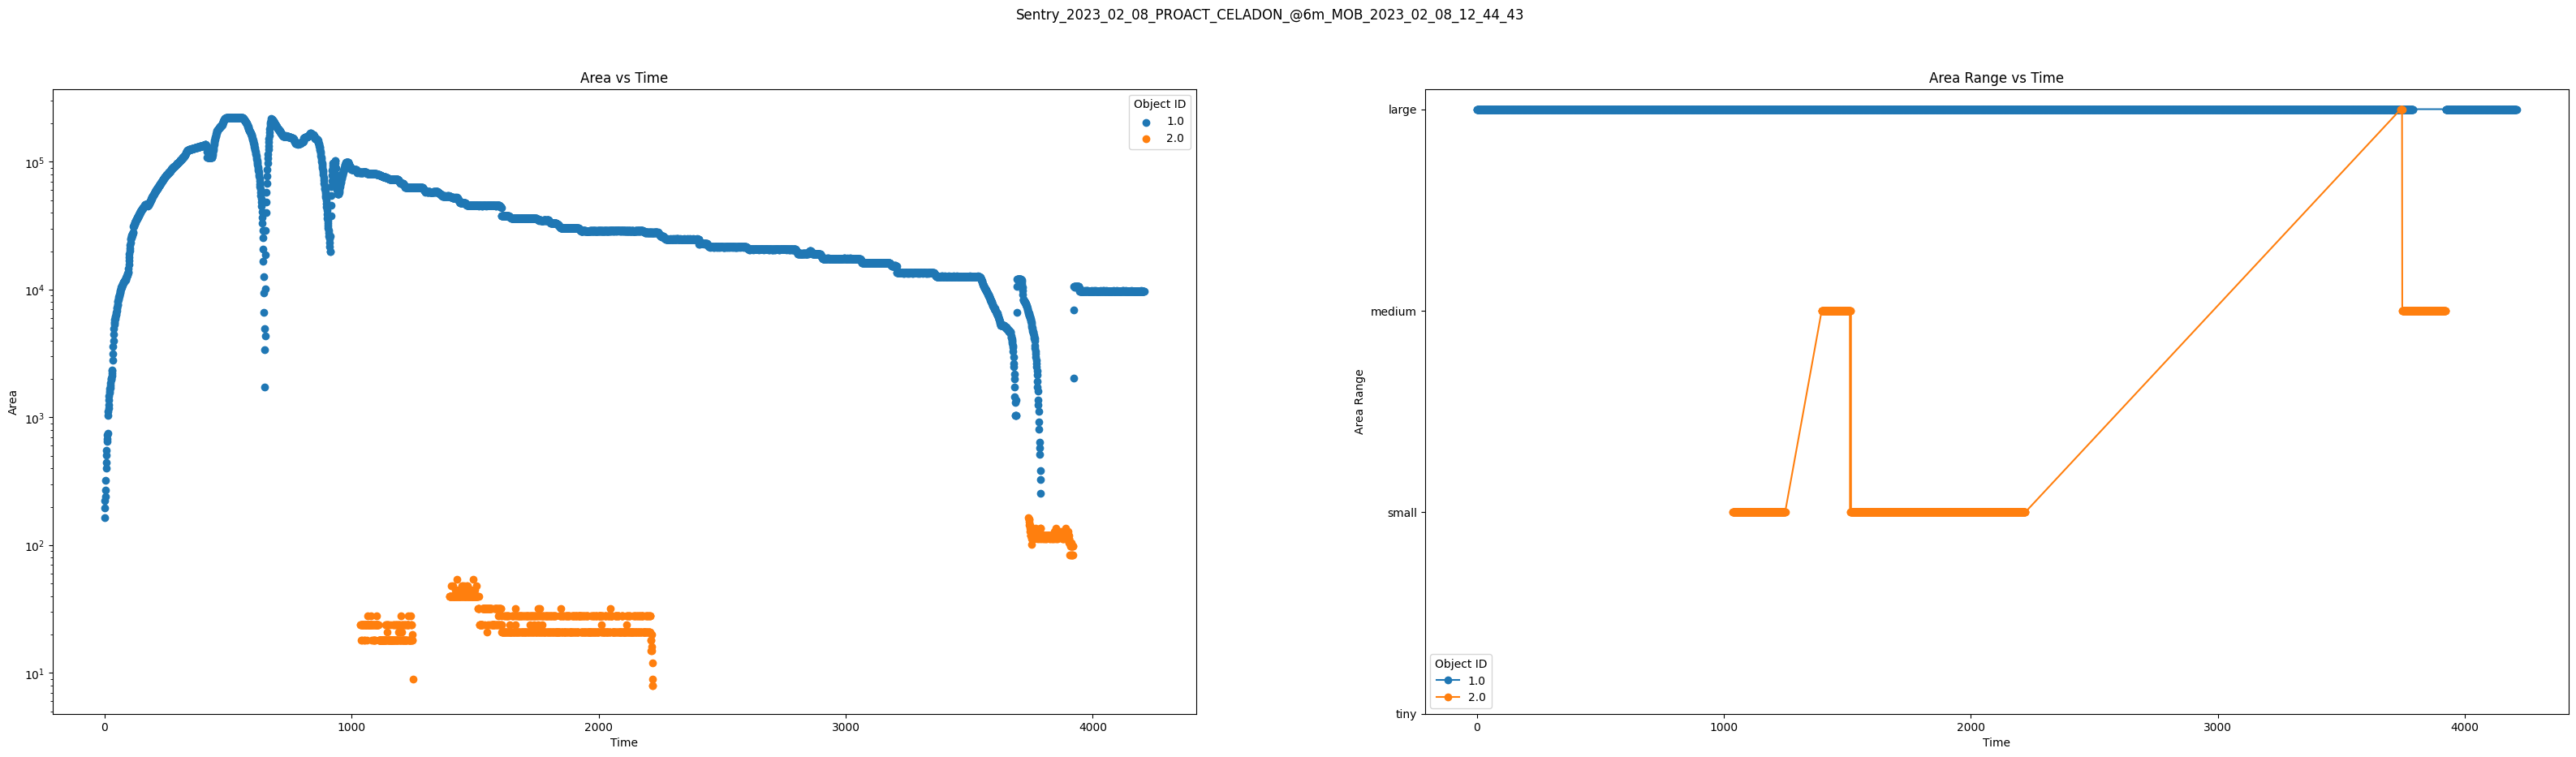

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_44_43


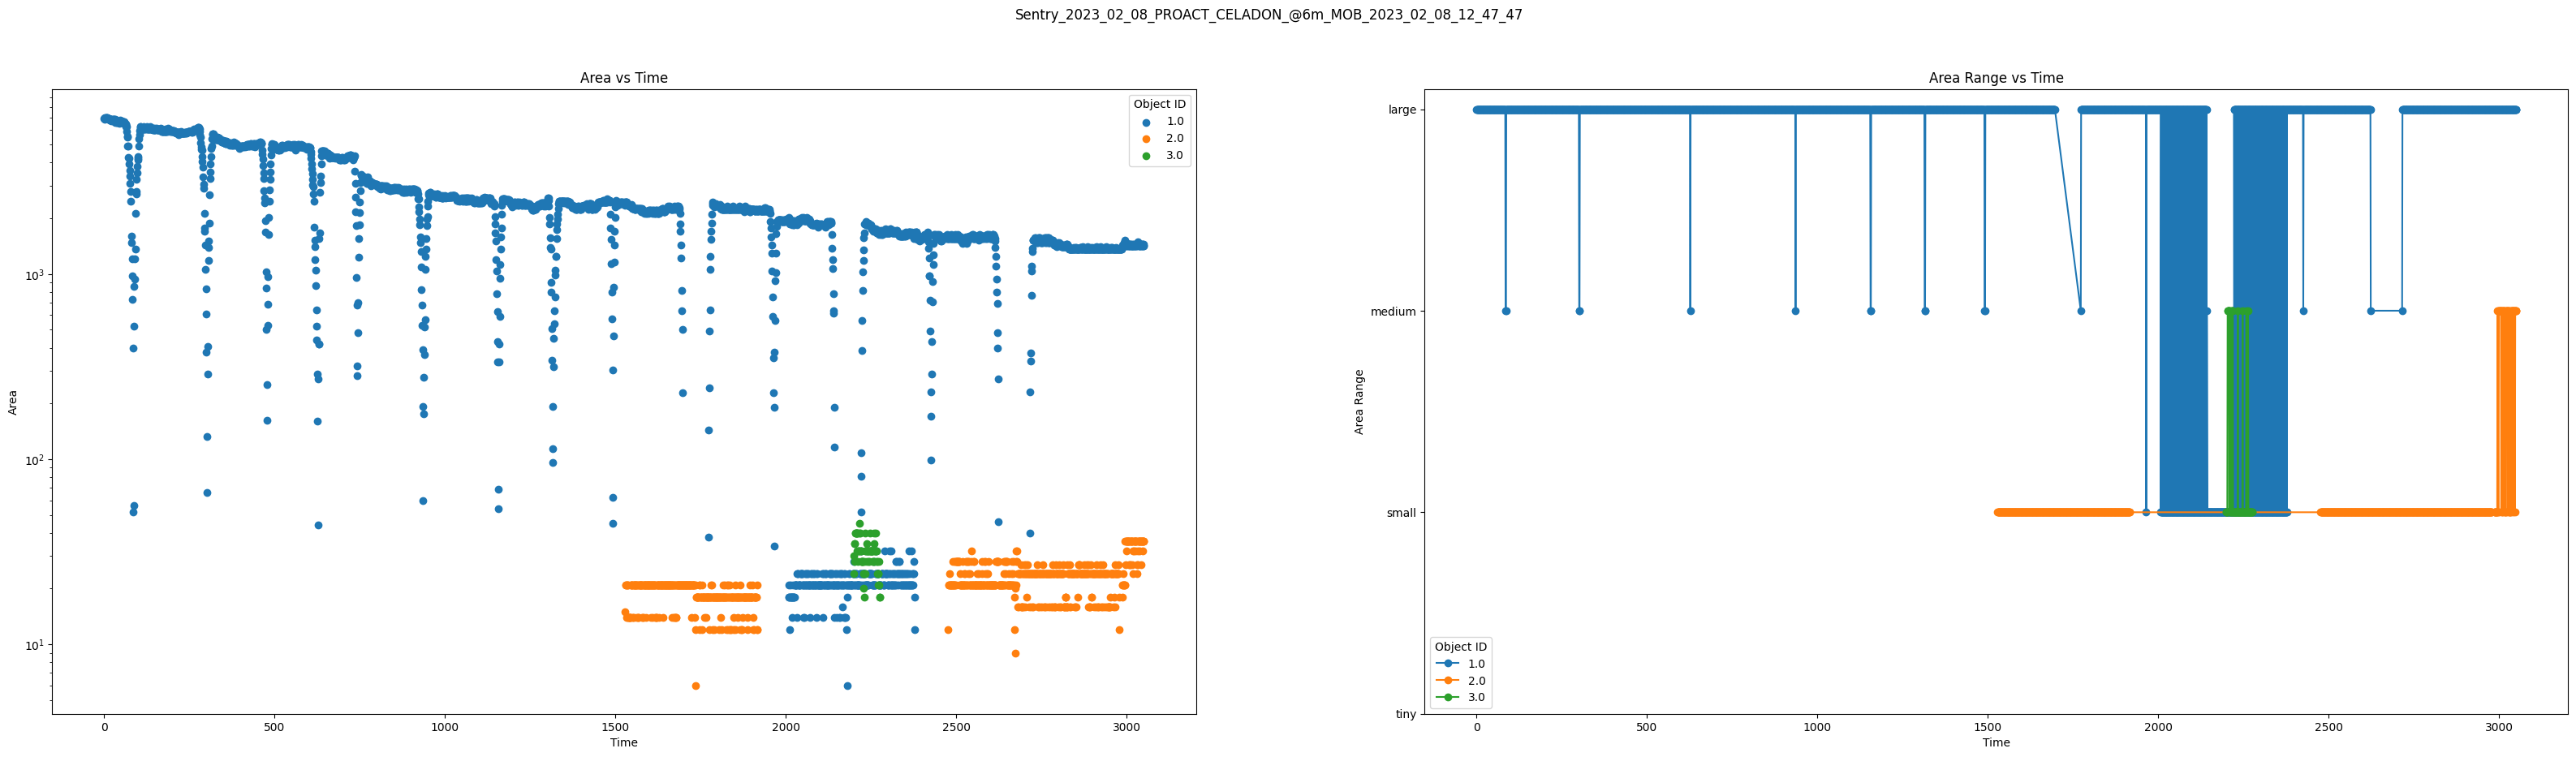

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_47_47


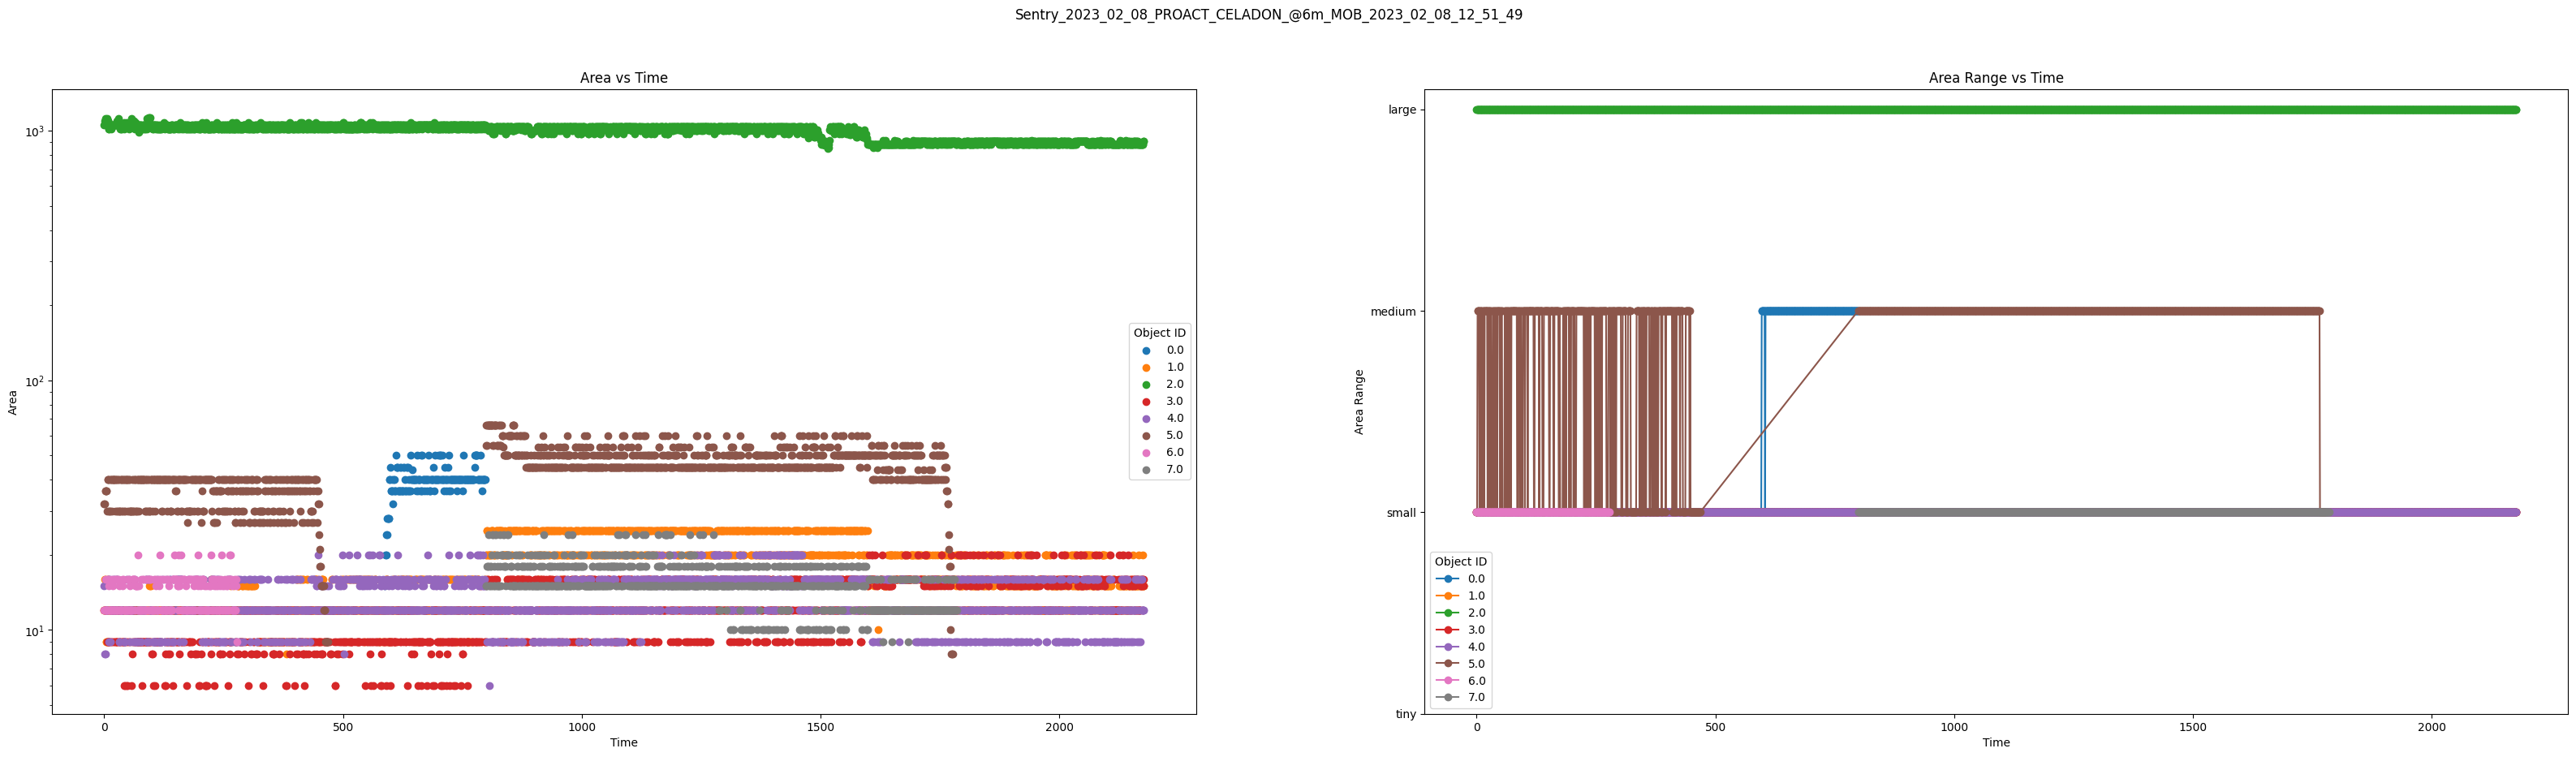

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_51_49


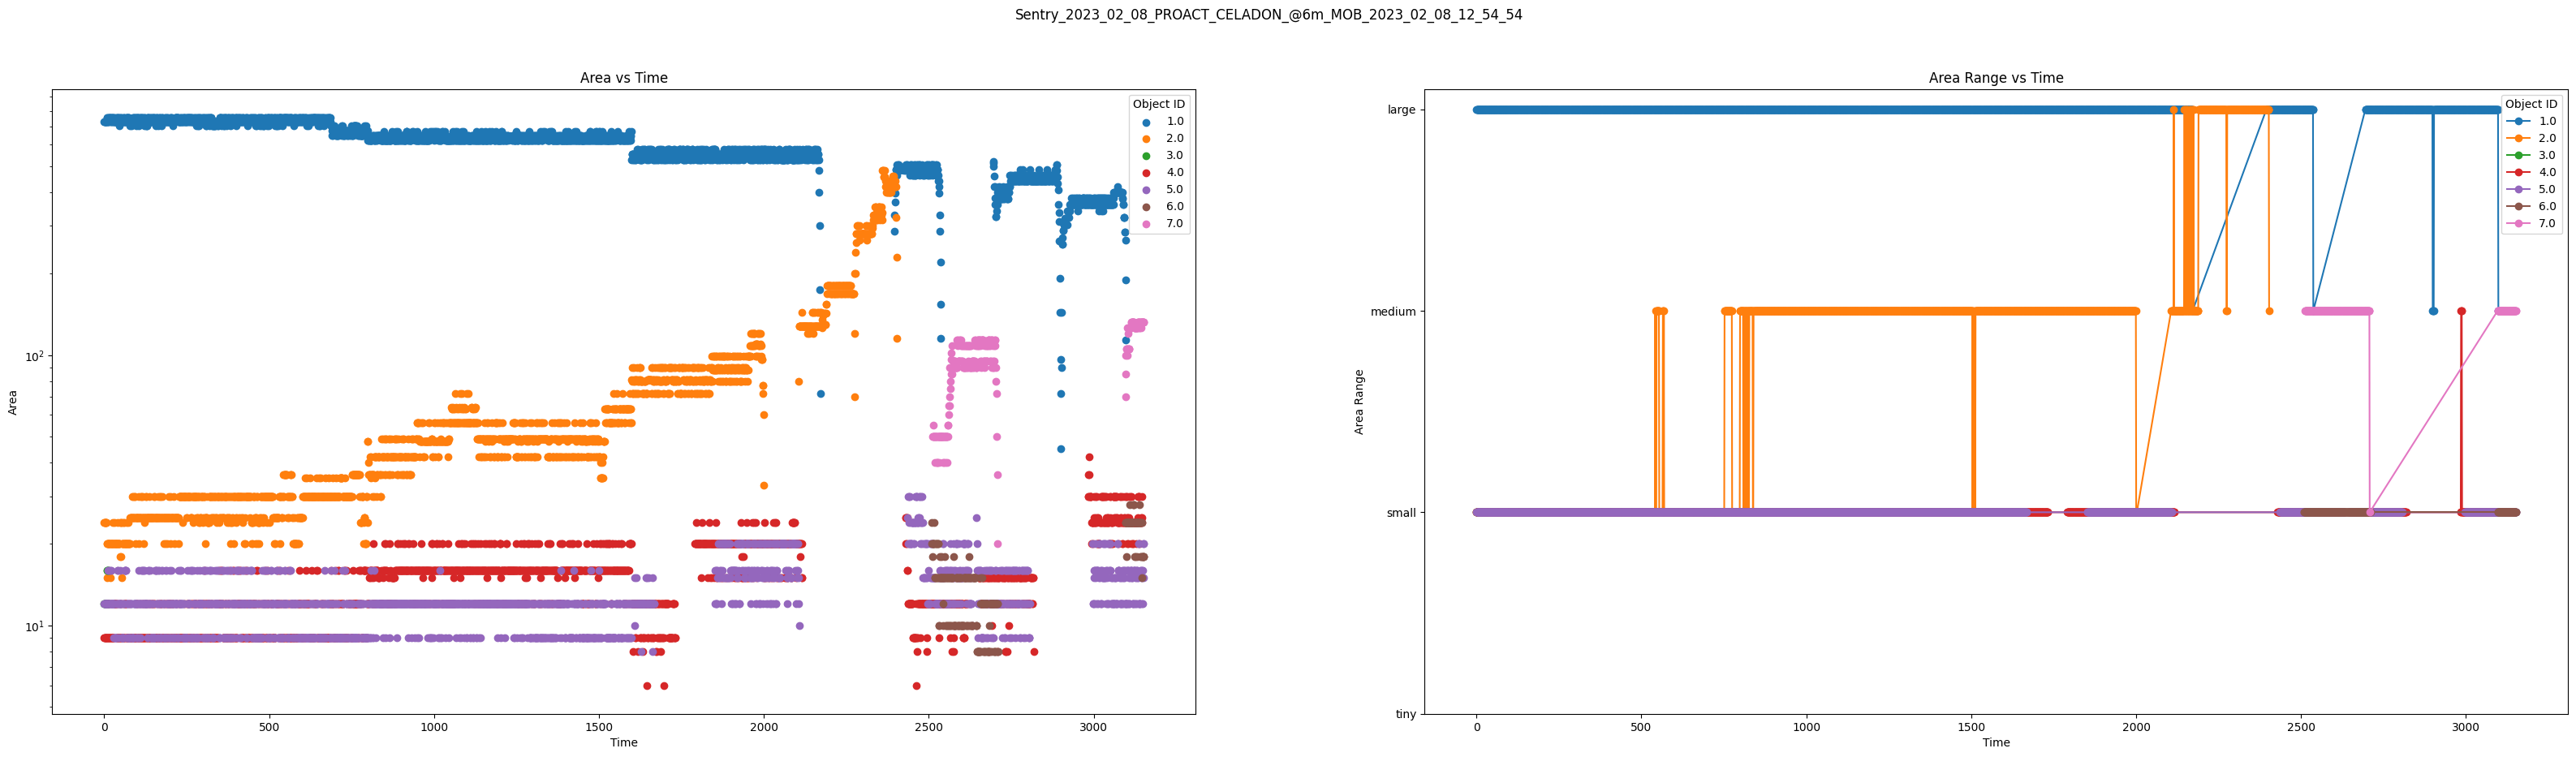

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_54_54


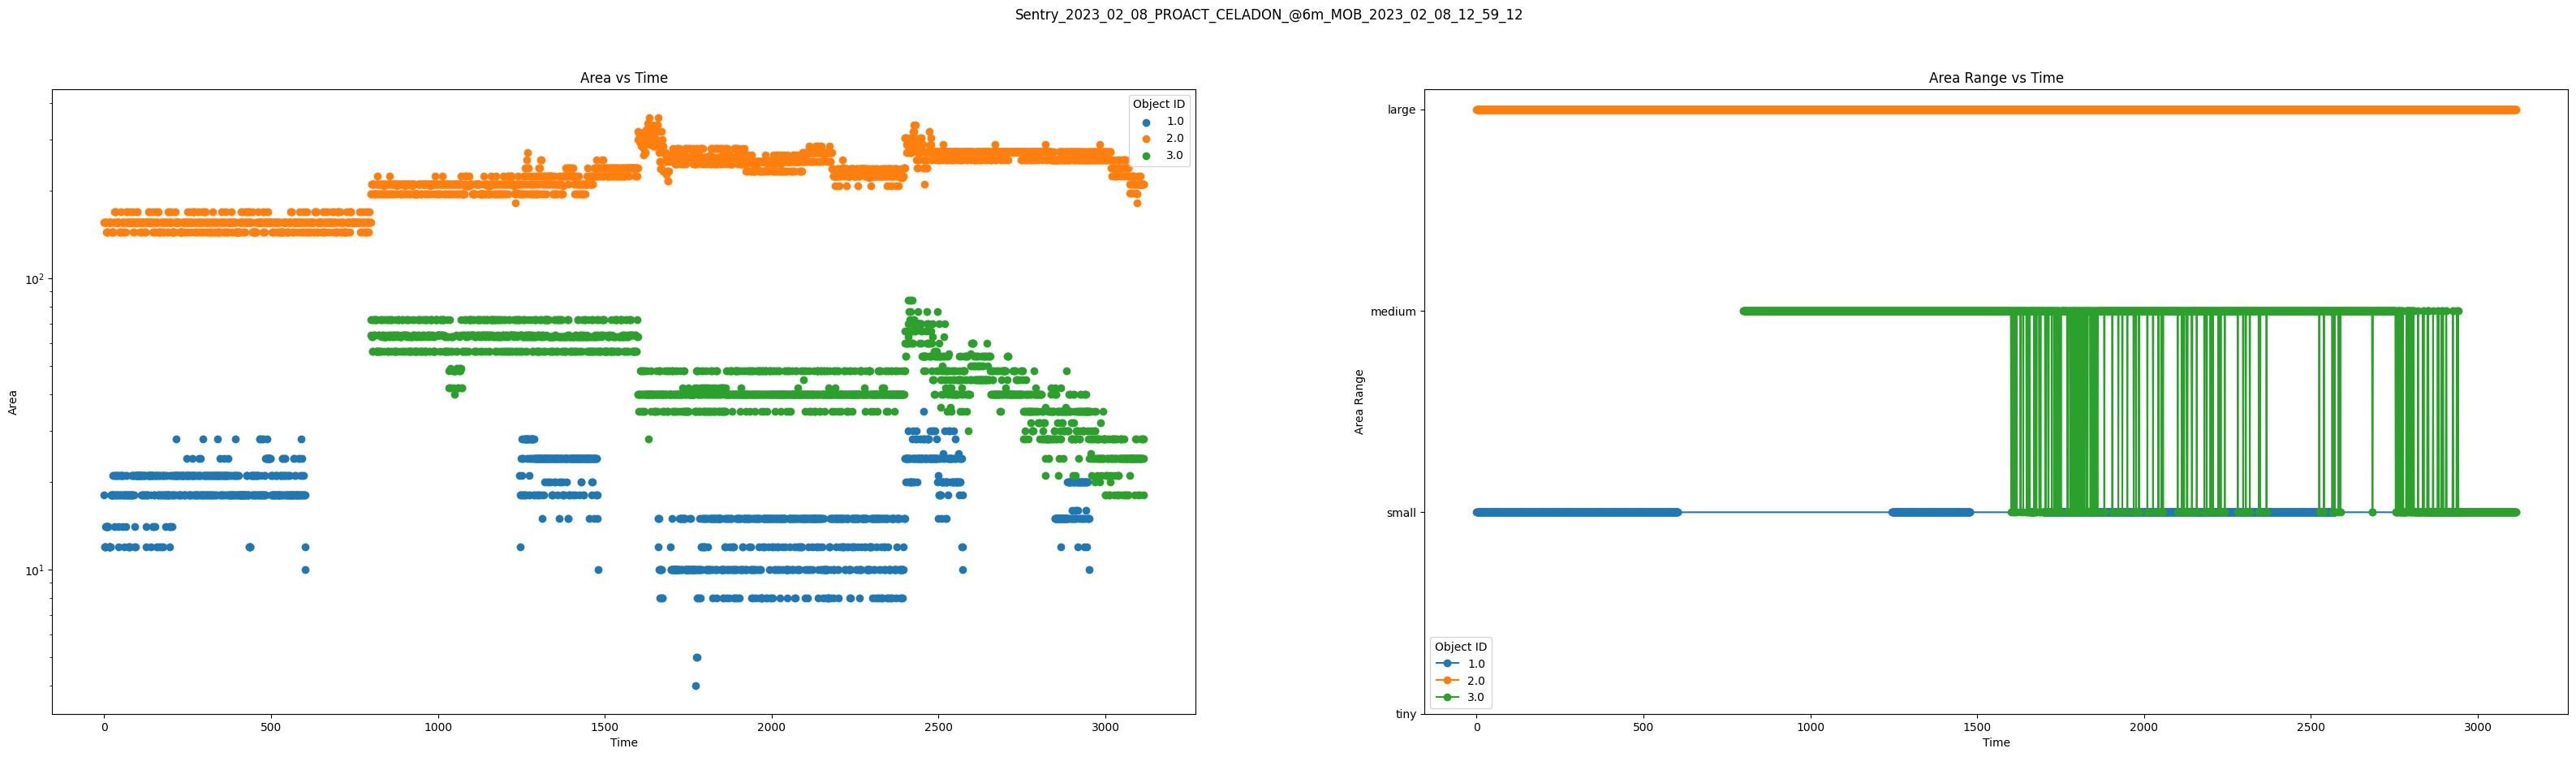

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_12_59_12


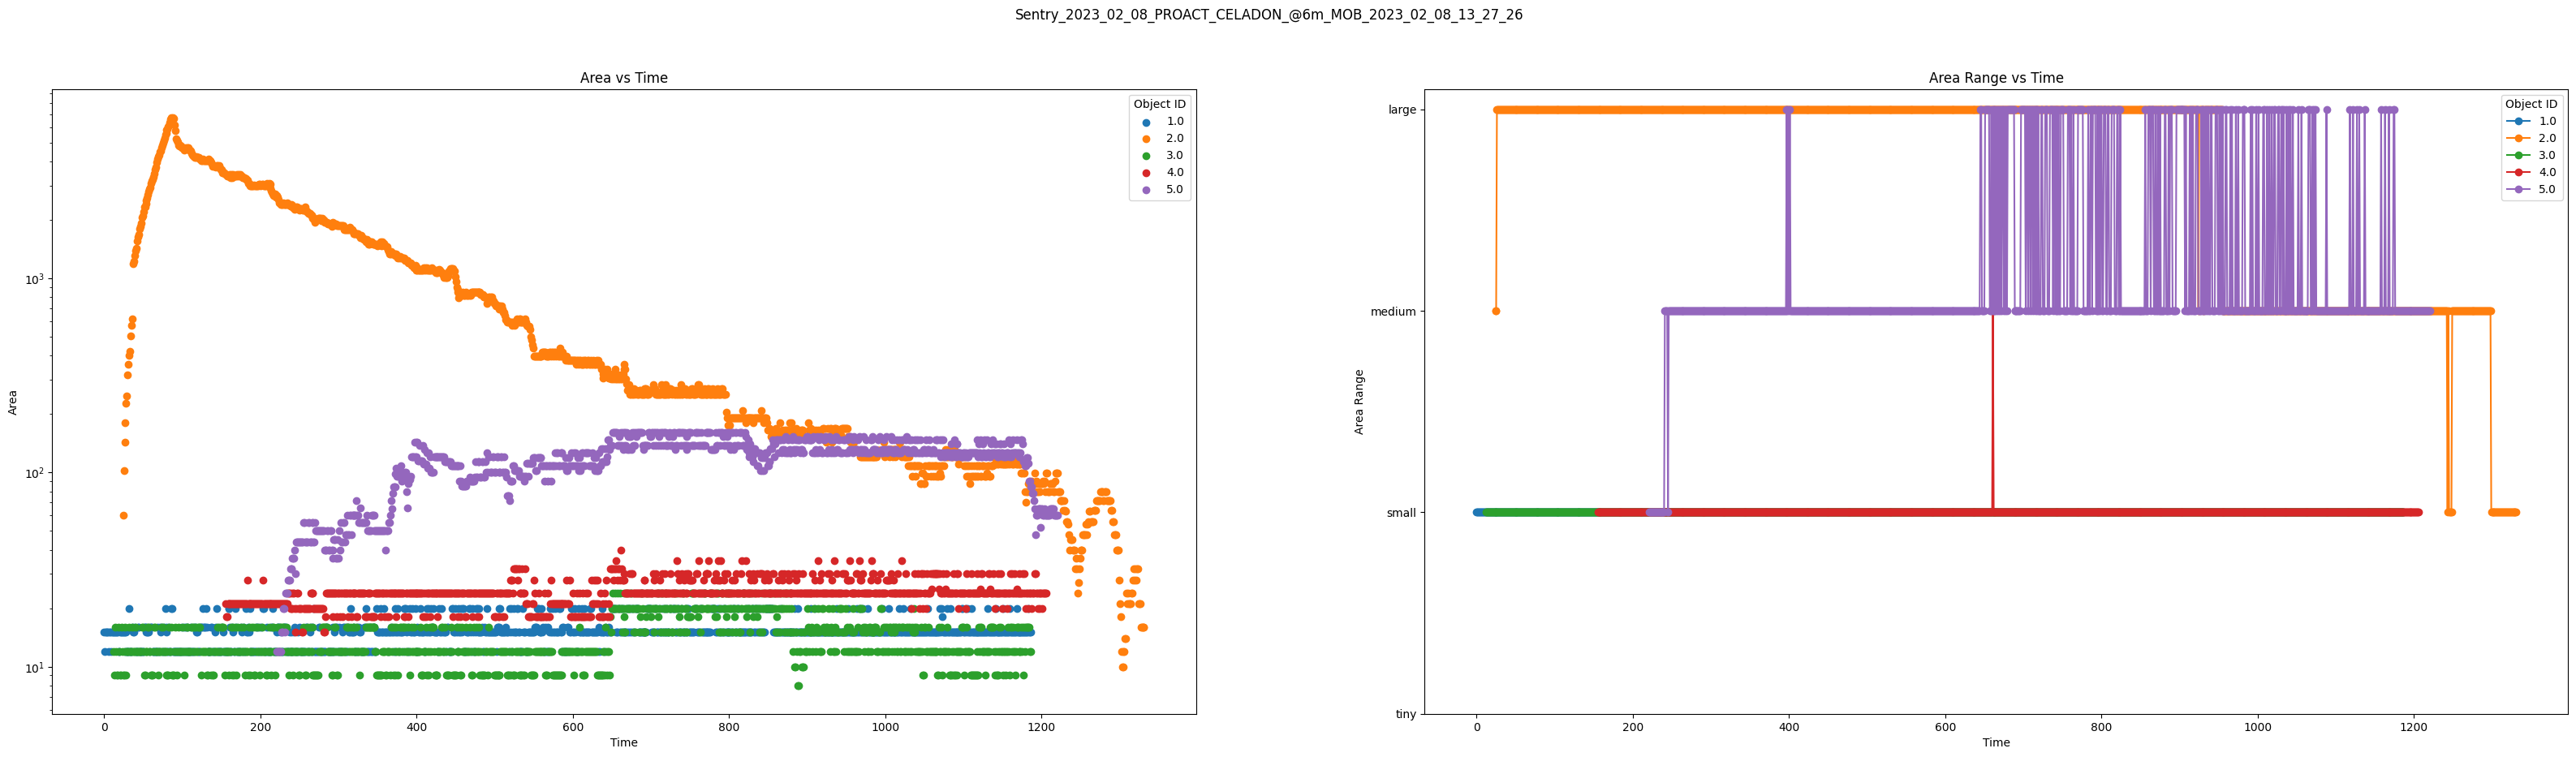

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_13_27_26


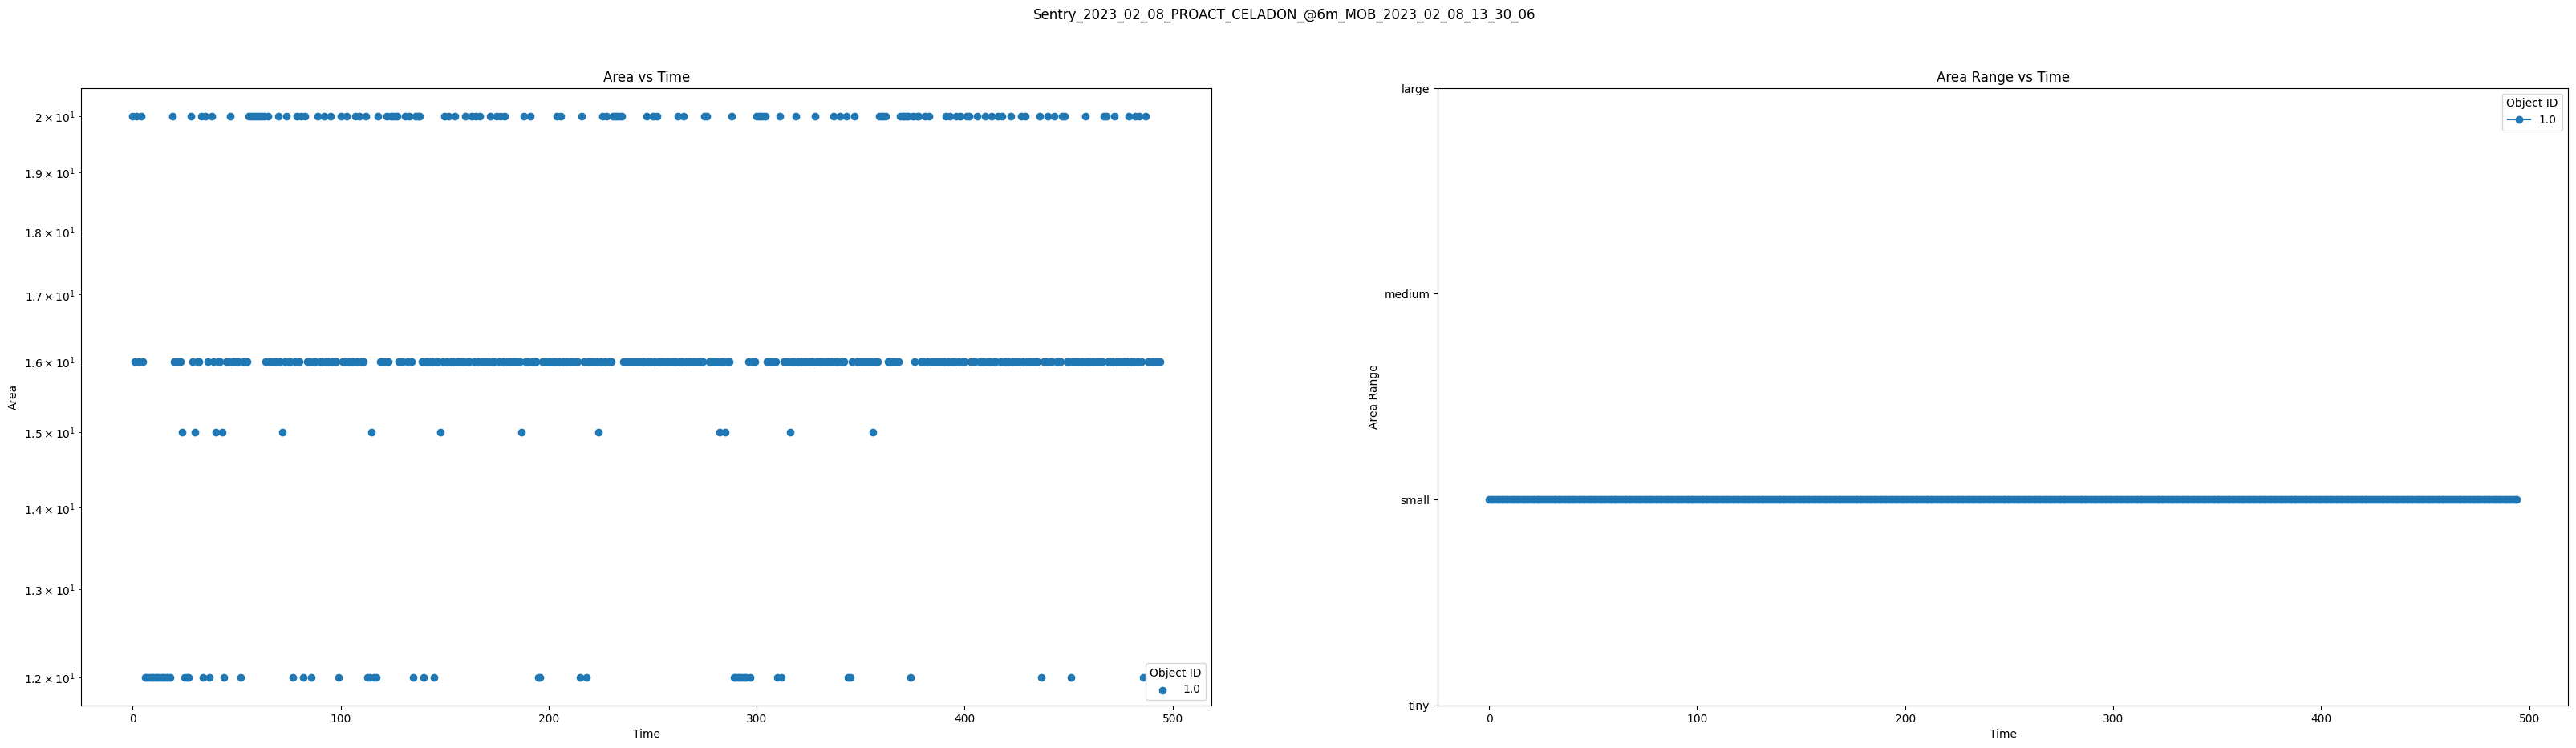

Plotted sequence Sentry_2023_02_08_PROACT_CELADON_@6m_MOB_2023_02_08_13_30_06
Error in sequence Sentry_2023_05_France_FB_WL_2023_05_16_16_09_52


In [6]:
for sequence in a:
    if a[sequence] == []:
        continue
    try:
        if len(np.unique(np.array(a[sequence])[:,1])) > 20:
            print(f'Error in sequence {sequence}')
            continue
        fig, axes = plt.subplots(1, 2, figsize=(40, 10))
        fig.suptitle(sequence)
        axes[0].set_title("Area vs Time")
        for unique_object in np.unique(np.array(a[sequence])[:,1]):
            x = np.array(a[sequence])[:,0][np.array(a[sequence])[:,1] == unique_object]
            y = np.array(a[sequence])[:,2][np.array(a[sequence])[:,1] == unique_object]
            axes[0].scatter(x,y, label=unique_object, marker='o')
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Area")
        axes[0].legend(title="Object ID")
        axes[0].set_yscale('log')

        b = np.array(a[sequence])
        # add column to b with discrete values for area ranges
        b = np.concatenate((b, np.zeros((b.shape[0], 1))), axis=1)
        for i, area_range in enumerate(area_ranges):
            b[b[:,2] >= area_range[0], 3] = i
        for unique_object in np.unique(b[:,1]):
            x = b[:,0][b[:,1] == unique_object]
            y = b[:,3][b[:,1] == unique_object]
            axes[1].plot(x,y, label=unique_object, marker='o')

        axes[1].set_title("Area Range vs Time")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Area Range")
        axes[1].set_yticks(np.arange(len(area_ranges_labels)), area_ranges_labels)
        axes[1].legend(title="Object ID")

        plt.show()  
        print(f'Plotted sequence {sequence}')
    except:
        print(f'Error in sequence {sequence}')

In [7]:
unique_objects = []
for sequence in a:
    if not a[sequence]:
        continue
    try:
        sequence_data = np.array(a[sequence])
        unique_objects_count = len(np.unique(sequence_data[:, 1]))
        if unique_objects_count > 20:
            print(f'Error in sequence {sequence}')
            continue
        category = classify_num_objects(unique_objects_count)
                
        unique_objects.append({"sequence": sequence, "unique_objects": unique_objects_count, "n_objects_range_label": category})
        
    except Exception as e:
        print(f'Error in sequence {sequence}')

Error in sequence Sentry_2022_08_Portugal_2022_08_16_11_29_37
Error in sequence Sentry_2022_08_Portugal_2022_08_29_20_32_19
Error in sequence Sentry_2023_05_France_FB_WL_2023_05_16_16_09_52


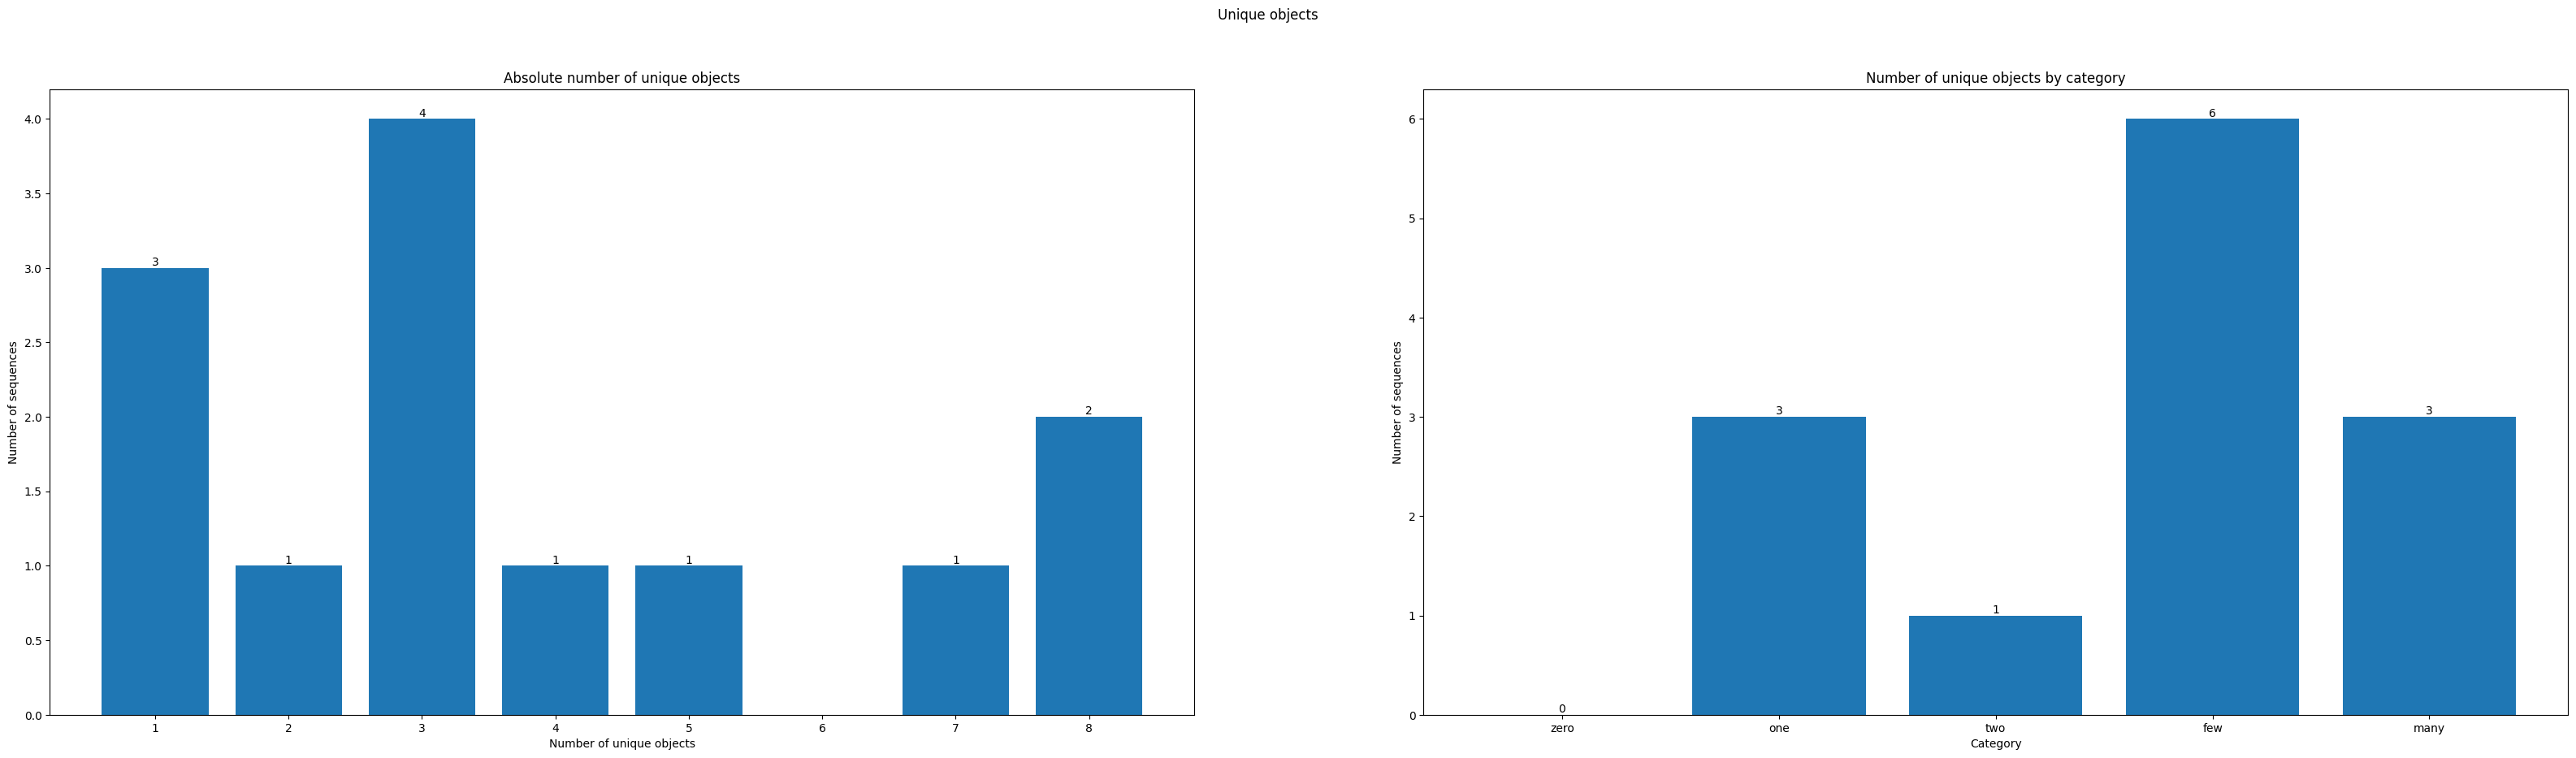

In [8]:
n_objects_ranges_tuples = [
        ("zero", [0, 1]), 
        ("one", [1, 2]), 
        ("two", [2, 3]),
        ("few", [3,7]),
        ("many", [7, 20])
    ]

fig, axes = plt.subplots(1, 2, figsize=(40, 10))
fig.suptitle("Unique objects")
axes[0].set_title("Absolute number of unique objects")
axes[0].set_xlabel("Number of unique objects")
axes[0].set_ylabel("Number of sequences")
frequency_counter = Counter([x['unique_objects'] for x in unique_objects])
axes[0].bar(list(frequency_counter.keys()), list(frequency_counter.values()))
numbers = list(frequency_counter.keys())
frequencies = list(frequency_counter.values())
for number, frequency in zip(numbers, frequencies):
    axes[0].text(number, frequency, str(frequency), ha='center', va='bottom')

axes[1].set_title("Number of unique objects by category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Number of sequences")
a = [(label, len([s for s in unique_objects if s['n_objects_range_label'] == label]))for label in [k for k, v in n_objects_ranges_tuples]]

axes[1].bar([x[0] for x in a], [x[1] for x in a])
for number, frequency in zip([x[0] for x in a], [x[1] for x in a]):
    axes[1].text(number, frequency, str(frequency), ha='center', va='bottom')

plt.show()
